<a href="https://colab.research.google.com/github/Saru03/Mini-project/blob/main/Mini_project_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Added 128 256 512

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers,optimizers,regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sn
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/Ogdataset.zip

Archive:  gdrive/MyDrive/Ogdataset.zip
   creating: dataset/cataract/
  inflating: dataset/cataract/_0_4015166.jpg  
  inflating: dataset/cataract/_1_5346540.jpg  
  inflating: dataset/cataract/_1_7703314.jpg  
  inflating: dataset/cataract/_10_3215668.jpg  
  inflating: dataset/cataract/_100_334408.jpg  
  inflating: dataset/cataract/_101_5139882.jpg  
  inflating: dataset/cataract/_101_709333.jpg  
  inflating: dataset/cataract/_102_1024926.jpg  
  inflating: dataset/cataract/_102_3990401.jpg  
  inflating: dataset/cataract/_103_5897328.jpg  
  inflating: dataset/cataract/_104_4607170.jpg  
  inflating: dataset/cataract/_105_5646774.jpg  
  inflating: dataset/cataract/_105_5956883.jpg  
  inflating: dataset/cataract/_106_5284713.jpg  
  inflating: dataset/cataract/_107_5060742.jpg  
  inflating: dataset/cataract/_108_750835.jpg  
  inflating: dataset/cataract/_108_8917257.jpg  
  inflating: dataset/cataract/_109_2006348.jpg  
  inflating: dataset/cataract/_109_2655056.jpg  
  inflati

In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4217 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
len(dataset)

132

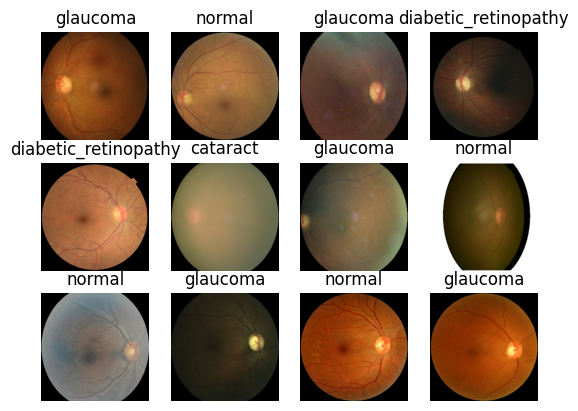

In [ ]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
plt.show()  # Add this to display the plot

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)

  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

105
13
14


In [ ]:
y_train = []
for images, labels in train_ds:
    y_train.extend(labels.numpy())

y_train = np.array(y_train)


In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu', ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3,3), activation='relu',),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3,3), activation='relu' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3,3), activation='relu' ),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu' ),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu' ),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', ),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax', ),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                 

In [ ]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)


history = model.fit(
    train_ds,
    epochs=80,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[reduce_lr],
    class_weight=class_weights_dict

)


Epoch 1/80
105/105 [==============================] - 40s 293ms/step - loss: 1.3240 - accuracy: 0.3659 - val_loss: 1.2233 - val_accuracy: 0.4423 - lr: 5.0000e-04
Epoch 2/80
105/105 [==============================] - 6s 55ms/step - loss: 1.0527 - accuracy: 0.5201 - val_loss: 0.8894 - val_accuracy: 0.5986 - lr: 5.0000e-04
Epoch 3/80
105/105 [==============================] - 6s 57ms/step - loss: 0.9126 - accuracy: 0.5747 - val_loss: 0.8658 - val_accuracy: 0.5889 - lr: 5.0000e-04
Epoch 4/80
105/105 [==============================] - 6s 58ms/step - loss: 0.8498 - accuracy: 0.6075 - val_loss: 0.7704 - val_accuracy: 0.6490 - lr: 5.0000e-04
Epoch 5/80
105/105 [==============================] - 6s 56ms/step - loss: 0.8064 - accuracy: 0.6251 - val_loss: 0.7258 - val_accuracy: 0.6899 - lr: 5.0000e-04
Epoch 6/80
105/105 [==============================] - 6s 57ms/step - loss: 0.7769 - accuracy: 0.6397 - val_loss: 0.6961 - val_accuracy: 0.7091 - lr: 5.0000e-04
Epoch 7/80
105/105 [==================

In [ ]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 23s 22ms/step - loss: 0.2718 - accuracy: 0.9085


In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

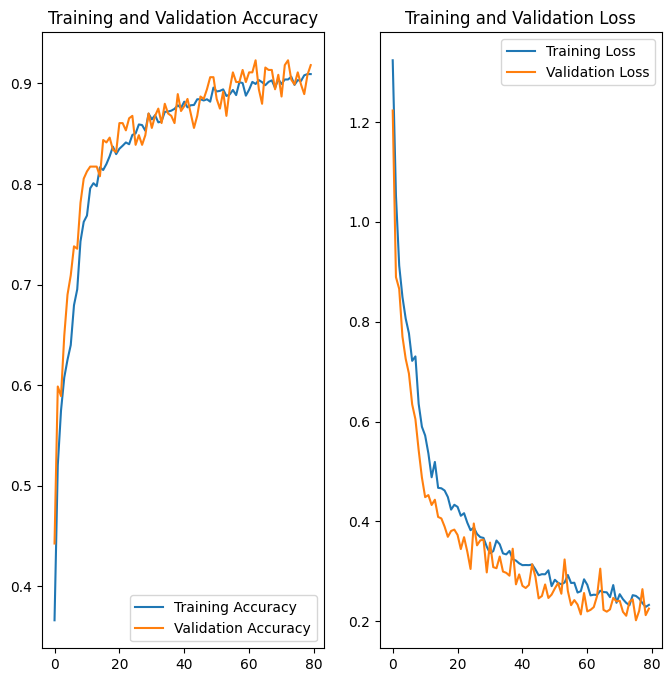

In [ ]:
EPOCHS=80
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Getting True Labels and Predictions from Validation Dataset
y_val = []
y_pred = []

for images, labels in val_ds:
    y_val.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays for sklearn metrics
y_val = np.array(y_val)
y_pred = np.array(y_pred)

# Calculate Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

1/1 [==============================] - 0s 26ms/step
Accuracy: 91.83%
Precision: 92.10%
Recall: 91.83%
F1-Score: 91.76%


Confusion Matrix:


Text(95.72222222222221, 0.5, 'Truth')

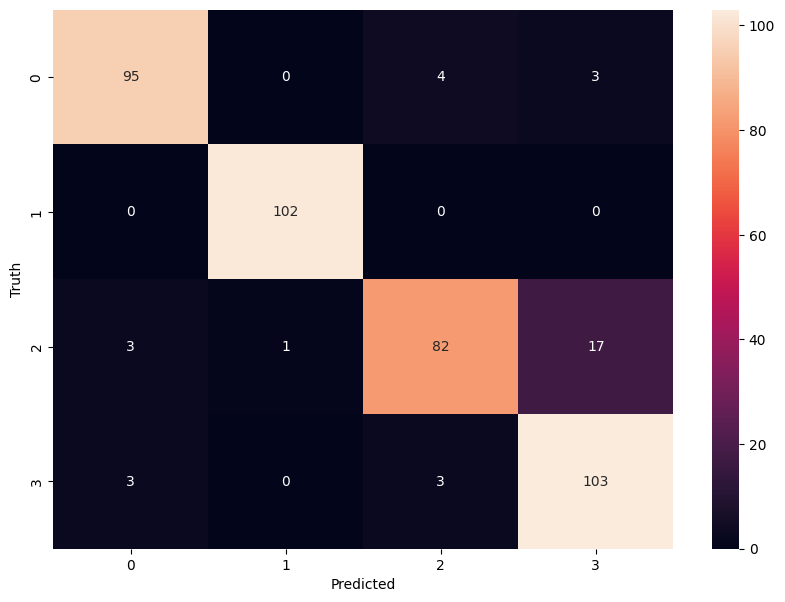

In [ ]:
print("Confusion Matrix:")
plt.figure(figsize = (10,7))
sn.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
IMAGE_SIZE = 224

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]

    # Apply the same data augmentation as in the training pipeline if needed
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
    ])

    img_array = data_augmentation(img_array, training=False)  # Data augmentation for testing
    return img_array
# Use this cell if you are working in Google Colab
uploaded = files.upload()

for img_name in uploaded.keys():
    img_path = img_name  # The uploaded file's name
    preprocessed_img = preprocess_image(img_path)

    predictions = model.predict(preprocessed_img)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")

    # Display the image with the prediction
    plt.imshow(image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)))
    plt.title(f"Predicted: {predicted_class} ({confidence}%)")
    plt.axis('off')
    plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
import tensorflow as tf

# Ensure the directory exists
directory = "../models"
if not os.path.exists(directory):
    os.makedirs(directory)

# Get the latest model version
model_version = max([int(i) for i in os.listdir(directory) if i.isdigit()] + [0]) + 1

# Assuming 'model' is your TensorFlow/Keras model
model_path = os.path.join(directory, str(model_version))
model.save(model_path)

print(f"Model saved at {model_path}")


In [ ]:
os.listdir("../models")

In [ ]:
from google.colab import files

# Zip the model directory (if the model is saved as a directory)
import shutil
shutil.make_archive(model_path, 'zip', model_path)

# Download the zipped model
files.download(f"{model_path}.zip")


In [ ]:
model.save('Mini_project_final2.h5')
from google.colab import files
files.download('Mini_project_final2.h5')





In [ ]:
# Save the model in the recommended Keras format if you want
model.save('Mini_project_final2.keras')
from google.colab import files
files.download('Mini_project_final2.keras')